Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [68]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [69]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [70]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [71]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2274
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [72]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [73]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 2274 files belonging to 9 classes.
Using 1820 files for training.


In [74]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 2274 files belonging to 9 classes.
Using 454 files for validation.


In [75]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

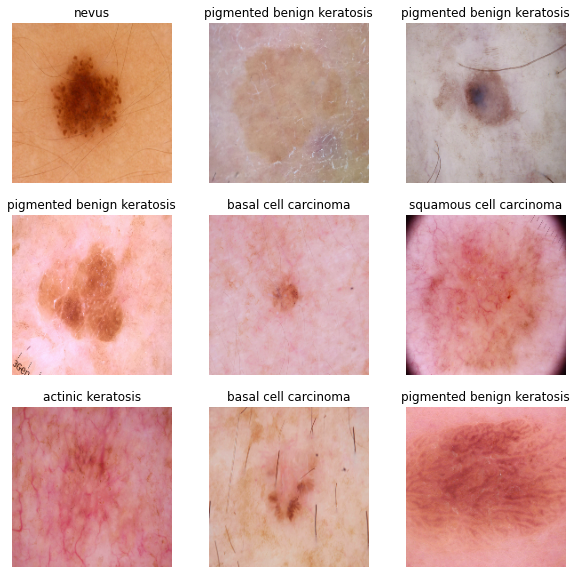

In [76]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))
for images , labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [77]:
for image_batch , labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [78]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [79]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [80]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [81]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 64)       

### Train the model

In [82]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 19s 81ms/step - loss: 2.2425 - accuracy: 0.1983 - val_loss: 1.9713 - val_accuracy: 0.2335
Epoch 2/20
57/57 [==============================] - 1s 20ms/step - loss: 1.8870 - accuracy: 0.2954 - val_loss: 1.7211 - val_accuracy: 0.4317
Epoch 3/20
57/57 [==============================] - 1s 20ms/step - loss: 1.5738 - accuracy: 0.4638 - val_loss: 1.6677 - val_accuracy: 0.3921
Epoch 4/20
57/57 [==============================] - 1s 19ms/step - loss: 1.4297 - accuracy: 0.5081 - val_loss: 1.5801 - val_accuracy: 0.4648
Epoch 5/20
57/57 [==============================] - 1s 20ms/step - loss: 1.3079 - accuracy: 0.5662 - val_loss: 1.4751 - val_accuracy: 0.4692
Epoch 6/20
57/57 [==============================] - 1s 20ms/step - loss: 1.2261 - accuracy: 0.5716 - val_loss: 1.3783 - val_accuracy: 0.5110
Epoch 7/20
57/57 [==============================] - 1s 20ms/step - loss: 1.1382 - accuracy: 0.6097 - val_loss: 1.2836 - val_accuracy: 0.5396
Epoch 8/20
5

### Visualizing training results

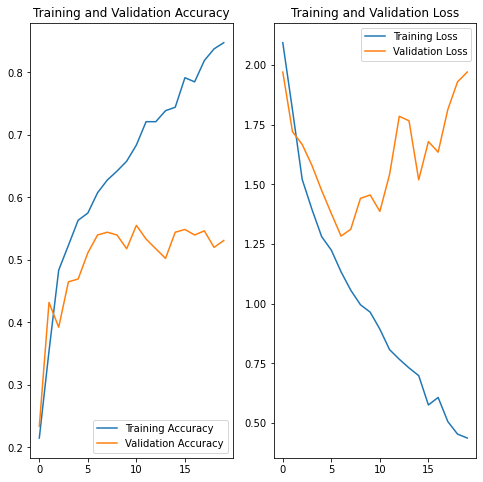

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

In [84]:
# After we have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

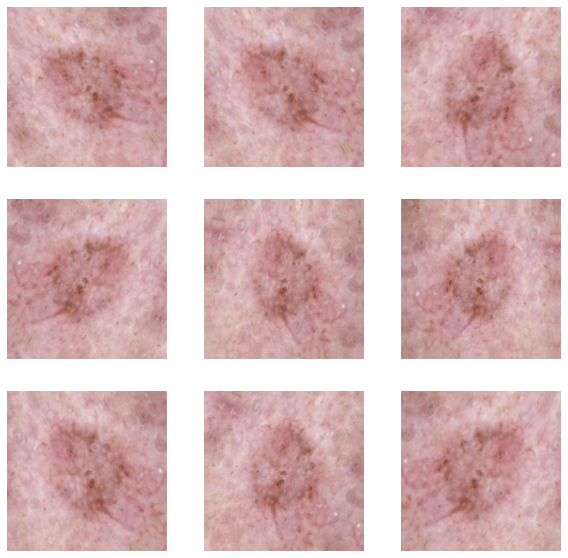

In [85]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [86]:
## Using Dropout layer as there is an evidence of overfitting in your findings

model = Sequential([
   data_augmentation,
   layers.experimental.preprocessing.Rescaling(1./255),
   layers.Conv2D(16, 3, padding='same', activation='relu'),
   layers.MaxPooling2D(),
   layers.Conv2D(32, 3, padding='same', activation='relu'),
   layers.MaxPooling2D(),
   layers.Conv2D(64, 3, padding='same', activation='relu'),
   layers.MaxPooling2D(),
   layers.Dropout(0.2),
   layers.Flatten(),
   layers.Dense(128 , activation='relu'),
   layers.Dense(num_classes)
])



### Compiling the model

In [87]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [88]:
# View the summary of all layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 64)       

### Training the model

In [89]:
## train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 2s 29ms/step - loss: 2.5217 - accuracy: 0.2140 - val_loss: 2.3421 - val_accuracy: 0.2070
Epoch 2/20
57/57 [==============================] - 1s 26ms/step - loss: 1.8655 - accuracy: 0.3265 - val_loss: 1.6065 - val_accuracy: 0.4361
Epoch 3/20
57/57 [==============================] - 1s 26ms/step - loss: 1.5898 - accuracy: 0.4508 - val_loss: 1.5676 - val_accuracy: 0.4251
Epoch 4/20
57/57 [==============================] - 1s 26ms/step - loss: 1.4508 - accuracy: 0.5025 - val_loss: 1.5182 - val_accuracy: 0.4339
Epoch 5/20
57/57 [==============================] - 1s 26ms/step - loss: 1.4121 - accuracy: 0.5183 - val_loss: 1.4633 - val_accuracy: 0.4449
Epoch 6/20
57/57 [==============================] - 1s 26ms/step - loss: 1.3237 - accuracy: 0.5316 - val_loss: 1.5244 - val_accuracy: 0.4714
Epoch 7/20
57/57 [==============================] - 2s 27ms/step - loss: 1.3618 - accuracy: 0.5319 - val_loss: 1.3921 - val_accuracy: 0.5132
Epoch 8/20
57

### Visualizing the results

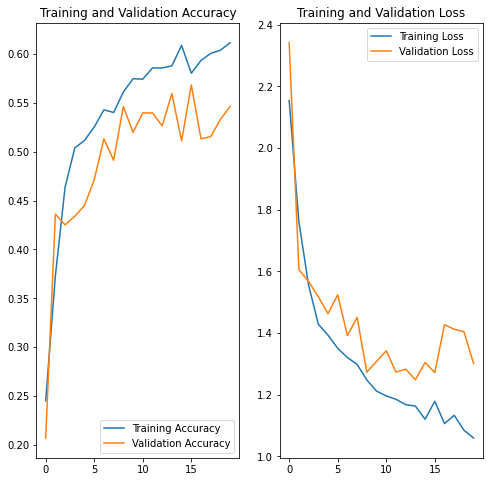

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [91]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print("one of the path to original dataset image",path_list[0])
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print("lesion of one of the image",lesion_list[0])
dataframe_dict = dict(zip(path_list, lesion_list))
df1 = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

one of the path to original dataset image /content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0024897.jpg
lesion of one of the image basal cell carcinoma


In [92]:
df1['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          380
nevus                         357
squamous cell carcinoma       181
vascular lesion               170
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64


#### - seborrheic keratosis has the least number of samples.
#### - pigmented benign keratosis classes dominate the data in terms proportionate number of samples.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [93]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [94]:
path_to_training_dataset=("/content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1B0A4DFC18>: 100%|██████████| 500/500 [00:18<00:00, 27.14 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 380 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1B0A4CA550>: 100%|██████████| 500/500 [00:19<00:00, 26.10 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1B120E9908>:   0%|          | 1/500 [00:00<01:01,  8.08 Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1B120775F8>: 100%|██████████| 500/500 [00:19<00:00, 25.89 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1B68D92908>: 100%|██████████| 500/500 [01:30<00:00,  5.53 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1019x717 at 0x7F1B0A58FEF0>: 100%|██████████| 500/500 [01:22<00:00,  6.04 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1B6AD5B080>: 100%|██████████| 500/500 [00:18<00:00, 26.51 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F1B0B183940>: 100%|██████████| 500/500 [00:41<00:00, 12.11 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1B0A532F60>: 100%|██████████| 500/500 [00:18<00:00, 26.95 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 170 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1B0A4B0EB8>: 100%|██████████| 500/500 [00:19<00:00, 25.10 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [95]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [96]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029331.jpg_b0d2e149-7771-46b9-b882-67dd885fe566.jpg',
 '/content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028155.jpg_9ede6e76-390b-471f-b9bc-8259265f5415.jpg',
 '/content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027786.jpg_1a5249bd-aca3-41e0-84d1-a87b7601e09d.jpg',
 '/content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029035.jpg_d7cae8d5-5776-45a3-a36c-7f9fa91e3ebe.jpg',
 '/content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/bas

In [97]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [98]:
dataframe_dict_new = dict(zip(path_list,lesion_list_new))

In [99]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df1.append(df2)

In [100]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          880
nevus                         857
squamous cell carcinoma       681
vascular lesion               670
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [101]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [102]:
data_dir_train="/content/gdrive/MyDrive/DataSetCNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6774 files belonging to 9 classes.
Using 5420 files for training.


#### **Todo:** Create a validation dataset

In [103]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6774 files belonging to 9 classes.
Using 1354 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [104]:
model = Sequential([
   data_augmentation,
   layers.experimental.preprocessing.Rescaling(1./255),
   layers.Conv2D(16, 3, padding='same', activation='relu'),
   layers.MaxPooling2D(),
   layers.Conv2D(32, 3, padding='same', activation='relu'),
   layers.MaxPooling2D(),
   layers.Conv2D(64, 3, padding='same', activation='relu'),
   layers.MaxPooling2D(),
   layers.Dropout(0.2),
   layers.Flatten(),
   layers.Dense(128 , activation='relu'),
   layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [105]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [106]:
## train your model for 40 epochs
epochs=40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
170/170 [==============================] - 42s 233ms/step - loss: 2.2015 - accuracy: 0.2144 - val_loss: 1.4719 - val_accuracy: 0.4682
Epoch 2/40
170/170 [==============================] - 40s 229ms/step - loss: 1.5025 - accuracy: 0.4429 - val_loss: 1.3900 - val_accuracy: 0.5030
Epoch 3/40
170/170 [==============================] - 40s 227ms/step - loss: 1.3901 - accuracy: 0.4772 - val_loss: 1.3675 - val_accuracy: 0.4874
Epoch 4/40
170/170 [==============================] - 40s 226ms/step - loss: 1.3039 - accuracy: 0.4984 - val_loss: 1.1965 - val_accuracy: 0.5650
Epoch 5/40
170/170 [==============================] - 40s 227ms/step - loss: 1.2219 - accuracy: 0.5372 - val_loss: 1.4082 - val_accuracy: 0.4956
Epoch 6/40
170/170 [==============================] - 39s 225ms/step - loss: 1.2008 - accuracy: 0.5481 - val_loss: 1.2092 - val_accuracy: 0.5502
Epoch 7/40
170/170 [==============================] - 39s 223ms/step - loss: 1.1264 - accuracy: 0.5635 - val_loss: 1.1498 - val_ac

#### **Todo:**  Visualize the model results

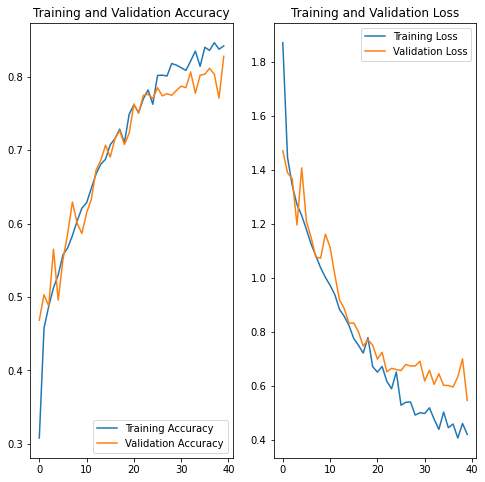

In [107]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Yes the class rebalance helped.
Adding a Dropout 0.2 resulted in good validation accuracy and avoided overfitting.

